# Lepton, Jet pt uncertainties



In [1]:
run ../prep_ana.py

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading plotting specs...
8 or 13 TeV:
Loading 8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?True
Correct MET?True
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [2]:
%matplotlib inline

In [3]:
df_da_a = rp.read_root(data_path+"/muon_2012A_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_b = rp.read_root(data_path+"/muon_2012B_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_c = rp.read_root(data_path+"/muon_2012C_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_d = rp.read_root(data_path+"/muon_2012D_complete.root", columns=columns+["runNum", "eventNumb"])

df_da = pd.concat([df_da_a, df_da_b, df_da_c, df_da_d]).reset_index()

In [4]:
df_da_a_el = rp.read_root(data_path+"/electron_2012A_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_b_el = rp.read_root(data_path+"/electron_2012B_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_c_el = rp.read_root(data_path+"/electron_2012C_complete.root", columns=columns+["runNum", "eventNumb"])
df_da_d_el = rp.read_root(data_path+"/electron_2012D_complete.root", columns=columns+["runNum", "eventNumb"])

df_da_el = pd.concat([df_da_a_el, df_da_b_el, df_da_c_el, df_da_d_el]).reset_index()
df_da = pd.concat( [df_da, df_da_el] ).reset_index()
df_da = df_da.drop(np.where(df_da[["runNum", "eventNumb"]].duplicated())[0])

## Lepton, Jet Scale uncertainty

In [5]:
from sklearn.externals import joblib
#load random forest
random_forest = joblib.load("../RF/Jan_22_fDY_fTT.jbl")

#Set-up pre-cuts data frame
#pre_df = pre_cuts(df, diff_charge=False)
#pre_df_da = pre_cuts(df_da, diff_charge=False)

#Add random forest prediction score to 
pred_fTT = random_forest["clf_fTT"].predict_proba(np.float32(df[random_forest["features_fTT"]].values))
df["pred_fTT_WW"] = pred_fTT[:,0]
pred_fDY = random_forest["clf_fDY"].predict_proba(np.float32(df[random_forest["features_fDY"]].values))
df["pred_fDY_WW"] = pred_fDY[:,0]
pred_fTT = random_forest["clf_fTT"].predict_proba(np.float32(df_da[random_forest["features_fTT"]].values))
df_da["pred_fTT_WW"] = pred_fTT[:,0]
pred_fDY = random_forest["clf_fDY"].predict_proba(np.float32(df_da[random_forest["features_fDY"]].values))
df_da["pred_fDY_WW"] = pred_fDY[:,0]

In [8]:
def calc_cross_stuff(df_mc, df_data, flavor="both", ):
    lumi = 19.7e3
    eff  = .155985#this had to be changed previously
    Br   = (3*.108)**2. 
    
    df_mc_c = df_mc[df_mc.lep1_Charge != df_mc.lep2_Charge]
    df_data_c = df_data[df_data.lep1_Charge != df_data.lep2_Charge]
    
    df_mc_c_s = df_mc[df_mc.lep1_Charge == df_mc.lep2_Charge]
    df_data_c_s = df_data[df_data.lep1_Charge == df_data.lep2_Charge]
    
    N_mc = sum([ rf_ana(df_mc_c[df_mc_c.process_decay == process], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in ['WW', 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu', 'GluGluToWWTo4L'] ])
    N_Wjets = rf_ana(df_data_c_s, flavor=flavor).shape[0] -  np.array([ rf_ana(df_mc_c_s[(df_mc_c_s.process_decay == process) ], flavor=flavor).weight.values.sum()*scales[process] for process in scales.keys() if process not in [ 'W1JetsToLNu','W2JetsToLNu','W3JetsToLNu','W3JetsToLNu'] ]).sum()
    N_mc += abs(N_Wjets)
    
    N_data = rf_ana(df_data_c, flavor=flavor).shape[0]
    
    N_ww_select = rf_ana(df_mc_c[df_mc_c.process_decay == "WW"], flavor=flavor).weight.values.sum()*scales["WW"] +\
                rf_ana(df_mc_c[df_mc_c.process_decay == "GluGluToWWTo4L"], flavor=flavor).weight.values.sum()*scales["GluGluToWWTo4L"]
    N_ww_tot = df_ww[df_ww.process_decay == "WW"].weight.values.sum()*scales["WW"] +\
                df_ww[df_ww.process_decay == "GluGluToWWTo4L"].weight.values.sum()*scales["GluGluToWWTo4L"]

    ratio_s_t = N_ww_select / N_ww_tot

    return {"lumi": lumi, "eff": eff, "Br": Br, "N_mc": N_mc, "N_data": N_data, "ratio_s_t": ratio_s_t, "N_ww_select":N_ww_select, "N_Wjets": N_Wjets}

In [9]:
def cross_calc(df_mc, df_data, flavor="both", fiducial=False, **kwargs):
    if kwargs:
        var = kwargs
    else:
        var = calc_cross_stuff(df_mc, df_data, flavor)
    lumi = var["lumi"]
    eff = var["eff"]
    Br = var["Br"]
    N_mc = var["N_mc"]
    N_data = var["N_data"]
    ratio_s_t = var["ratio_s_t"]
    N_ww_select = var["N_ww_select"]
    N_Wjets = var["N_Wjets"]
    
    if fiducial == False:
        return  (N_data - N_mc) / (lumi * eff * Br *ratio_s_t)
    else:
        return (N_data - N_mc) / (lumi * eff ) 

In [10]:
def rf_ana( df, flavor="both", random_forest=random_forest):
  
  rf_cuts = (df.pred_fTT_WW > .6) & (df.pred_fDY_WW > .972)
  same_cuts = (df.lep_Type < 0) & rf_cuts 
  diff_cuts =  (df.lep_Type > 0) & rf_cuts


  #return cuts_ana(df)
  if flavor=="both": return pd.concat( [df[same_cuts], df[diff_cuts]] )
  elif flavor=="same": return df[same_cuts]
  elif flavor=="diff": return df[diff_cuts]

In [7]:
def lep_scale_shift(data, lep_pt=1.003, ): #0.2% muon scale and 0.3% electron scale
    #leptons
    data.lep1_pt = data.lep1_pt * lep_pt
    data.lep2_pt = data.lep2_pt * lep_pt
    data.mll = data.mll * lep_pt**.5
    data.qT = data.qT * lep_pt
    #ADD qT, recoil

    #MET results
    data.metMod = data.metMod - (data.lep1_pt + data.lep2_pt)/ lep_pt * (lep_pt - 1) 
    data.metProj = data.METProj - (data.lep1_pt + data.lep2_pt) / lep_pt * (lep_pt - 1) 
    
def jet_scale_shift(data, jet_pt=1.025 ): #2.5% jet scale
    #jets
    data.HT = data.HT * jet_pt
    data.jet1_pt = data.jet1_pt * jet_pt
    
    #MET results
    data.metMod = data.metMod - data.HT / jet_pt * ( jet_pt - 1)
    data.metProj = data.METProj - data.HT / jet_pt * ( jet_pt - 1)
     

### Masks

In [11]:
flavor = 'both'

#All the mask we will need
mc_lepton_Z =  (df.mll < 76) |  (df.mll > 106)
data_lepton_Z =  (df_da.mll < 76) |  (df_da.mll > 106)
mc_leptons_pt = (df.lep1_pt > 27) & (df.lep2_pt > 17) & (df.mll > 30) & mc_lepton_Z
mc_jets_pt = ((df.jet1_pt > 32) | (df.jet1_pt < 5 )) & ((df.jet2_pt > 32) | (df.jet2_pt < 5 ))  
data_leptons_pt = (df_da.lep1_pt > 27) & (df_da.lep2_pt > 17) & (df_da.mll > 30) & data_lepton_Z
data_jets_pt = ((df_da.jet1_pt > 32) | (df_da.jet1_pt < 5 )) & ((df_da.jet2_pt > 32) | (df_da.jet2_pt < 5 ))  

def masks( mc_leptons_pt):
    mc_lepton_Z =  (df.mll < 76) |  (df.mll > 106)
    data_lepton_Z =  (df_da.mll < 76) |  (df_da.mll > 106)
    mc_leptons_pt = (df.lep1_pt > 27) & (df.lep2_pt > 17) & (df.mll > 30) & mc_lepton_Z
    return mc_leptons_pt


### Leptons

In [12]:
#First calc 
no_change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt], flavor=flavor, )

#Scale shift and redo pre calculation
lep_scale_shift(df, )
mc_leptons_pt = masks( mc_leptons_pt )

change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt ], flavor=flavor,)

print "Lepton scale up: ",  no_change, change, no_change - change

#Shift leptons back to starting value and redo pre calc
lep_scale_shift(df, lep_pt=1. / 1.003)
mc_leptons_pt = masks( mc_leptons_pt )
#First calc
no_change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt ], flavor=flavor, )

#Scale shift to low end
lep_scale_shift(df, lep_pt=1. / 1.003)
mc_leptons_pt = masks( mc_leptons_pt )

#Pre calc and redo cross calc
change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt], flavor=flavor,)
print "Lepton scale down: ",  no_change, change, no_change - change

Lepton scale up:  62.5722485112 62.4731116734 0.0991368377871
Lepton scale down:  62.5722485112 62.689178379 -0.116929867863


### JETs

In [13]:
mc_jets_pt = ((df.jet1_pt > 31) | (df.jet1_pt < 5)) & ((df.jet2_pt > 31 )| (df.jet2_pt < 5)) 
data_jets_pt = ((df_da.jet1_pt > 31) | (df_da.jet1_pt < 5)) & ((df_da.jet2_pt > 31 )| (df_da.jet2_pt < 5)) 
def masks_jet( mc_leptons_jet):
    mc_jets_pt = ((df.jet1_pt > 31) | (df.jet1_pt < 5)) & ((df.jet2_pt > 31 )| (df.jet2_pt < 5)) 
    return mc_jets_pt

In [14]:
flavor = 'both'
mc_jets_pt = masks_jet(mc_jets_pt)
no_change = cross_calc(df[ mc_jets_pt], df_da[ data_jets_pt], flavor=flavor,)
jet_scale_shift(df)
mc_jets_pt = masks_jet(mc_jets_pt)
change = cross_calc(df[mc_jets_pt], df_da[data_jets_pt], flavor=flavor, )

print "Jet scale up: ",  no_change, change, no_change - change
jet_scale_shift(df, jet_pt=.975)
no_change = cross_calc(df[mc_jets_pt], df_da[data_jets_pt], flavor=flavor, )
jet_scale_shift(df, jet_pt=.975)
mc_jets_pt = masks_jet(mc_jets_pt)
change = cross_calc(df[ mc_jets_pt], df_da[data_jets_pt], flavor=flavor, )
print "Lepton scale down: ",  no_change, change, no_change - change

Jet scale up:  57.281414073 56.6810068835 0.600407189569
Lepton scale down:  56.6810068835 57.9204674711 -1.23946058766


## Resolution

In [15]:
def lep_resolution(data, lep_resolution=.017): #.006 is the muon resolution, 1.7 - 4.5% for electrons (I can't delieve the electrons are that big)
    #Leptons 1 & 2 
    lep1_delta = np.random.normal(loc=[0]*data.shape[0], scale=lep_resolution)
    lep2_delta = np.random.normal(loc=[0]*data.shape[0], scale=lep_resolution)
    
    data.lep1_pt = data.lep1_pt + lep1_delta
    data.lep2_pt = data.lep2_pt + lep2_delta
    #data.mll = 
    
    #MET
    data.metMod = data.metMod - lep1_delta - lep2_delta
    return lep1_delta, lep2_delta

def jet_resolution(data, jet_scale=.1):
    #Jets
    ht_delta = np.random.normal(loc=[0]*data.shape[0], scale=jet_scale) * np.sqrt(df.numb_jets)
    data.HT = data.HT + ht_delta 
    data.jet1_pt = data.jet1_pt + np.random.normal(loc=[0]*data.shape[0], scale=jet_scale)
    data.jet2_pt = data.jet2_pt + np.random.normal(loc=[0]*data.shape[0], scale=jet_scale)
    #MET
    data.metMod = data.metMod - ht_delta
    
    #Update leptons and jets 
    

### Leptons

In [16]:
data_lepton_Z =  (df_da.mll < 76) |  (df_da.mll > 106)
data_leptons_pt = (df_da.lep1_pt > 27) & (df_da.lep2_pt > 17) & (df_da.mll > 30) & data_lepton_Z

def lep_masks( ):
    mc_lepton_Z =  (df.mll < 76) |  (df.mll > 106)
    data_lepton_Z =  (df_da.mll < 76) |  (df_da.mll > 106)
    mc_leptons_pt = (df.lep1_pt > 27) & (df.lep2_pt > 17) & (df.mll > 30) & mc_lepton_Z
    return mc_leptons_pt

In [17]:
#First calc 
mc_leptons_pt = lep_masks()
no_change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt], flavor=flavor, )

#Scale shift and redo pre calculation
a = lep_resolution(df)
mc_leptons_pt = lep_masks()

change = cross_calc(df[mc_leptons_pt ], df_da[data_leptons_pt ], flavor=flavor,)

print "Lepton resolution up: ",  no_change, change, no_change - change

Lepton resolution up:  62.689178379 62.6881731091 0.0010052699569


Lepton resolution up:  62.6(Before) 60.3(After) 2.214(Delta)

This change is too large. Something is wrong.

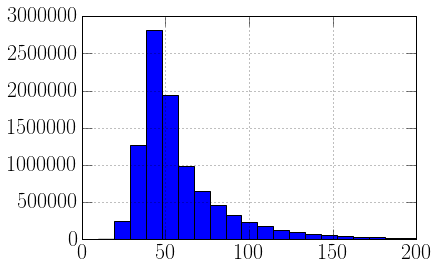

In [41]:
df.lep1_pt.hist(bins=20, range=(10, 200))

### JETs

In [18]:
mc_jets_pt = ((df.jet1_pt > 31) | (df.jet1_pt < 5)) & ((df.jet2_pt > 31 )| (df.jet2_pt < 5)) 
data_jets_pt = ((df_da.jet1_pt > 31) | (df_da.jet1_pt < 5)) & ((df_da.jet2_pt > 31 )| (df_da.jet2_pt < 5)) 
def masks_jet( mc_leptons_jet):
    mc_jets_pt = ((df.jet1_pt > 31) | (df.jet1_pt < 5)) & ((df.jet2_pt > 31 )| (df.jet2_pt < 5)) 
    return mc_jets_pt

In [19]:
flavor = 'both'
mc_jets_pt = masks_jet(mc_jets_pt)
no_change = cross_calc(df[ mc_jets_pt], df_da[ data_jets_pt], flavor=flavor,)
jet_resolution(df)
mc_jets_pt = masks_jet(mc_jets_pt)
change = cross_calc(df[mc_jets_pt], df_da[data_jets_pt], flavor=flavor, )

print "Jet scale up: ",  no_change, change, no_change - change

Jet scale up:  57.9204674711 57.9119975678 0.00846990333164


# Template Fits(move)

In [51]:
bin_mc = bin_df(pre_cuts(df), "pred_fTT_WW", range=(-.1, 1.1))
bin_data = bin_df(pre_cuts(df_da), "pred_fTT_WW", range=(-.1, 1.1))

In [53]:
bin_data

{'Da': [array([      0.,       0.,       0.,       0.,   14166.,   13407.,
           12075.,   11698.,   11293.,    9712.,    8178.,    6846.,
            6184.,    5814.,    6024.,    6126.,    6602.,    7075.,
            7512.,    7967.,    8333.,    8440.,    8697.,    8465.,
            8656.,    8387.,    8242.,    8313.,    8332.,    8667.,
            8869.,    9387.,    9914.,   11015.,   11911.,   13197.,
           14885.,   16979.,   19494.,   22914.,   28585.,   41822.,
           77485.,  173742.,  290349.,  115928.,       0.,       0.,
               0.,       0.], dtype=float32),
  array([-0.1  , -0.076, -0.052, -0.028, -0.004,  0.02 ,  0.044,  0.068,
          0.092,  0.116,  0.14 ,  0.164,  0.188,  0.212,  0.236,  0.26 ,
          0.284,  0.308,  0.332,  0.356,  0.38 ,  0.404,  0.428,  0.452,
          0.476,  0.5  ,  0.524,  0.548,  0.572,  0.596,  0.62 ,  0.644,
          0.668,  0.692,  0.716,  0.74 ,  0.764,  0.788,  0.812,  0.836,
          0.86 ,  0.884,  0.908

In [77]:
processes = {'DY': ['DYJetsToLL_M-10to50', 'DYJetsToLL_M-50'],
'Top': ['ttbar_semileptonic', 'ttbar_leptonic', 'Tbar_tW-channel', 'Tbar_s-channel', 'T_t-channel','Tbar_t-channel', 'T_s-channel'],
'WW': ['WW']}

chi_arr = np.zeros(bin_mc['WW'][0].shape[0])
current_ = {'DY':1 * chi_arr , 'Top':1 * chi_arr , 'WW':1 * chi_arr }
alphas = {'DY':1, 'Top':1, 'WW':1}
skip_list = []
for key in processes:
    for process in processes[key]:
        chi_arr += alphas[key] * bin_mc[process][0]
        current_[key] += alphas[key] * bin_mc[process][0]
        skip_list.append(process)
    #Update alpha
for key in current_:
    print key, 2*(chi_arr - bin_data['Da'][0] ).sum()
    print key, (bin_data['Da'][0]  - np.array([current_[i] for i in current_ if i != key])).sum()
    num =  2*(chi_arr - bin_data['Da'][0])
    demon =  (bin_data['Da'][0]  - np.array([current_[i] for i in current_ if i != key]))
    demon[demon < .1 ] = 1
    print key, (num / demon).sum()
for process in bin_mc:
    if process not in skip_list+['plotting']:
        chi_arr += bin_mc[process][0]
        
chi_sq_score  = ((chi_arr - bin_data['Da'][0] )**2 / bin_data['Da'][0]).sum()



WW -110442.073776
WW 1161991.05244
WW -60.5544451576
Top -110442.073776
Top 1181009.84632
Top -59.4752459532
DY -110442.073776
DY 2134189.17501
DY -17.0342332468


In [72]:
a = np.array([12,32,0,0,0])

In [78]:
current_

{'DY': array([      0.        ,       0.        ,       0.        ,
              0.        ,    2849.80810547,    5176.63360596,
           6515.28662109,    7369.20336914,    7637.23046875,
           7044.91943359,    5968.16357422,    5223.80786133,
           5059.52844238,    4233.86804199,    4551.48071289,
           5019.14001465,    4958.46826172,    5736.16870117,
           6469.79138184,    6530.82861328,    6875.26757812,
           7488.48742676,    7369.87512207,    7502.76879883,
           7511.30395508,    6868.29516602,    7213.52526855,
           7119.12963867,    7360.85107422,    7652.34240723,
           8073.23400879,    8249.45532227,    8801.9921875 ,
           9496.76049805,   10516.8236084 ,   11714.25805664,
          13656.97912598,   15524.67578125,   18119.03186035,
          21425.47912598,   26087.01660156,   37887.68164062,
          71463.62158203,  165975.07421875,  284031.88671875,
         112950.99414062,       0.        ,       0.        ,
  